# Imbizo project: Receptive field formation in plastic EI balanced networks

From Clopath C, Vogels T P, Froemke R C, Sprekeler H, bioRxiv (2016); doi: https://doi.org/10.1101/066589]

## Imports and style

In [136]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

from mystyle import mystyle
from EI_balance_functions import *
from plotting_EI import *

sns.set_style("ticks") 
# sns.set(rc={"axes.facecolor": "black", 'figure.facecolor':'black'})
#sns.set(font="Verdana")
plt.style.use('dark_background')
plt.rcParams.update(mystyle())

[autoreload of plotting_EI failed: Traceback (most recent call last):
  File "/Users/luciaarancibia/miniconda3/envs/imbizo/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/Users/luciaarancibia/miniconda3/envs/imbizo/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/Users/luciaarancibia/miniconda3/envs/imbizo/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/luciaarancibia/Code/IMBIZO/project/plotting_EI.py", line 123

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Input signals: 
The activities $s_i(t)$ of the stimulus channels are generated from independent **Ornstein-Uhlenbeck** processes with a time constant of 50 ms by subtracting a constant $c$, setting all negative values to zero and then rescaling the signal to have a mean firing rate of 1 (arbitrary units). The constant $c$ controls the lifetime sparseness (Franco et al., 2007) of the signals. For our choice of $c$, we obtained a lifetime sparseness of $$\large a = 〈s_i〉_t^2/ 〈s_i^2〉_t = 0.146$$, where $〈·〉_t$ denotes a temporal average.




#### From https://towardsdatascience.com/stochastic-processes-simulation-the-ornstein-uhlenbeck-process-e8bff820f3

The Ornstein-Uhlenbeck (OU for short) process satisfies the stochastic differential equation (SDE):

$$\large dX_t = α(γ - X_t) dt + βdW_t $$

where $W_t$ is a Brownian motion, α and β are positive constants.

The solution to the SDE is:

$$\large X_t = X-0e^{-αt} + γ(1 - e^{-αt}) + βe^{-αt} ∫_0^te^{αs} dW_s $$

its asymptotic mean and variance are $γ$ and $β² / 2α$ respectively. Hence, the distribution of the process is $N(γ, β² / 2α)$.

### Ornstein-Uhlenbeck (OU) process
As a point of terminology: this type of process is commonly known as a drift-diffusion model or Ornstein-Uhlenbeck (OU) process. The model is a combination of a drift term toward $𝑥^∞$
 and a diffusion term that walks randomly. You may sometimes see them written as continuous stochastic differential equations, but here we are doing the discrete version to maintain continuity in the tutorial. The discrete version of our OU process has the following form:

$$ \large x_{k+1} = x^\infty + \lambda(x_k - x^\infty) + \sigma\eta $$

where $\eta$ is sampled from a standard normal distribution (𝜇=0,𝜎=1).

#### Single signal

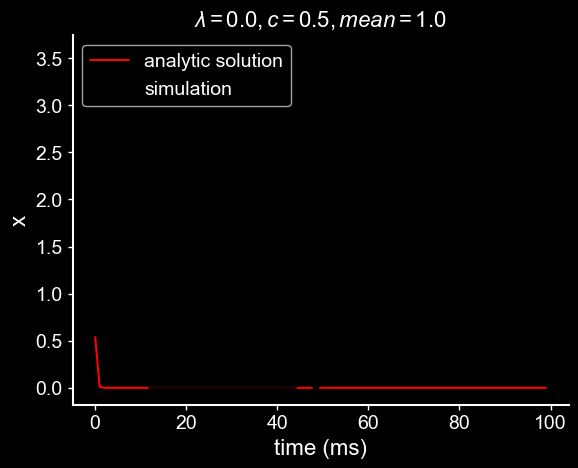

In [3]:
decay = 1/50 # τ = 50ms
c = 0.5
mean = 1 
sigma = 0.1
dur = 100
dt = 1.
t = np.arange(0, dur, dt)

sig1 = OU_input_signal(decay, c, mean, sigma, dur, dt)
plot_dynamics(sig1, t, decay, c, mean)

#### Several signals

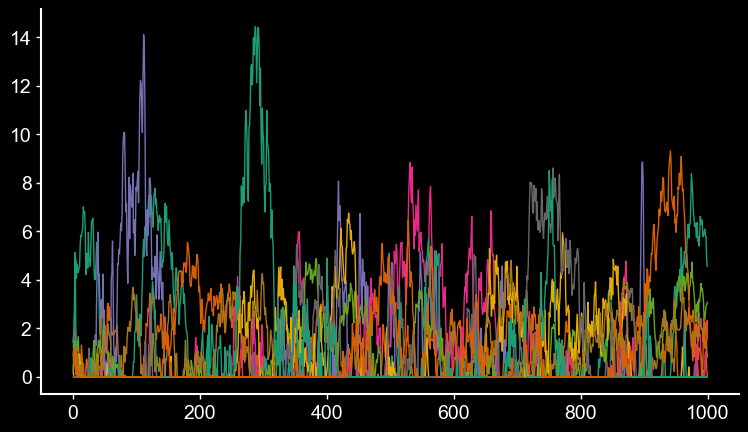

In [4]:
n_signals = 10
np.random.seed(0)

decay = 1/50 # τ = 50ms
c = 20
mean = 1 
sigma = 100
dur = 1000
dt = 1.
t = np.arange(0, dur, dt)

signals = np.zeros((n_signals, len(t)))
for i in range(n_signals):
    signals[i,:] = OU_input_signal(decay, c, mean, sigma, dur, dt)

sns.set_palette("Dark2")
fig = plt.figure(figsize=(9,5))
# plt.title('$\lambda=%0.1f, c=%0.1f, mean=%0.1f$' % (decay, c, mean), fontsize=16)
# plt.plot(t, signals.T + np.arange(0,n_signals*np.ceil(np.max(signals)),np.ceil(np.max(signals))))          # simulated data pts
# #plt.ylim(0.6, 1.6)

# plt.xlabel('time (ms)')
# plt.ylabel('x')
# plt.show()

# print('mean value: ', np.mean(signals,1))
# print('sparsity: ', sparsity(signals))

plt.plot(signals.T, linewidth=1)
plt.show()

## Input populations: filtered signals

The excitatory and inhibitory input signals Ei and Ij are generated assuming that the inputs each have a tuning to sensory stimuli. These stimuli are modeled as N = 10 different sensory stimulus channels with time-dependent activities $s_j(t)$ (which could, e.g., be sound amplitude at different frequencies). The activity of input neuron $i$ is calculated by a sum of the stimulus channels, weighted with tuning strengths 

$ T_{ij}^{E/I}: E_i(t) = ∑_jT_{ij}^E s_j(t)$
and 
$I_i(t) = ∑_jT_{ij}^I s_j(t)$

The input tuning is Gaussian: 

$T_{ij}^{E/I} ∝ exp(-(i-j)^2/2σ^2_{E/I})$ 

and normalized such that $Σ_j T_{ij} = 1$ for all $i$. The parameters $σ_{E/I}$ denote the tuning widths for excitation and inhibition, respectively. In the limit of very small tuning width, the input signals are exact copies of the activity in the sensory stimulus channels; for very large tuning widths, they are an average thereof.

In [5]:
sigma_E = 1.
sigma_I = 1.
n_E = n_signals
n_I = 1

E_pop = input_filters(signals, sigma=sigma_E, n_filters=n_E)
I_pop = input_filters(signals, sigma=sigma_I, n_filters=n_I)

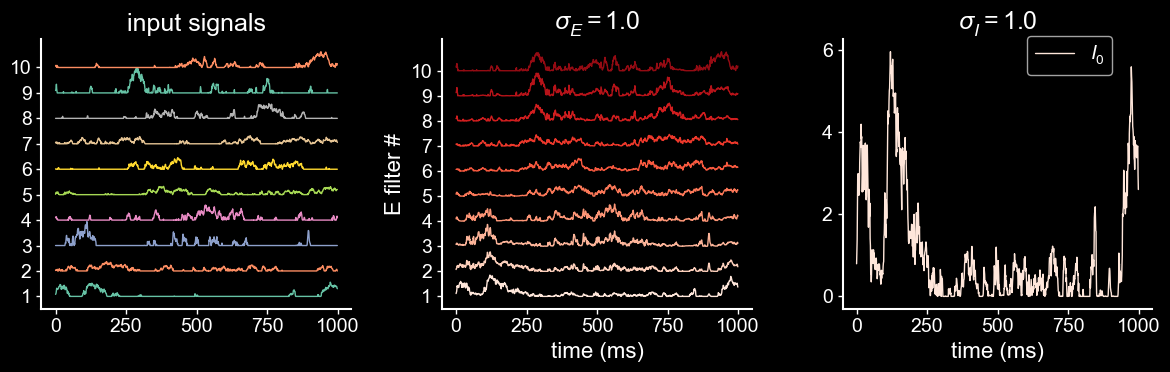

In [6]:
fig = plt.figure(figsize=(12,4))
scale_s = np.ceil(np.max(signals))
scale_E = np.ceil(np.max(E_pop))

sns.set_palette('Set2', n_signals)
plt.subplot(1,3,1)
plt.title('input signals')
plt.plot(t, signals.T + np.arange(0,n_signals*scale_s,scale_s),linewidth=1.)  
plt.yticks(np.arange(0,n_signals*scale_s,scale_s), labels=np.arange(1,n_signals+1))     
#plt.ylim(-5., (n_signals+1)*scale_s)

sns.set_palette('Reds', n_E)
plt.subplot(1,3,2)
plt.plot(t, E_pop.T + np.arange(0,n_E*scale_E,scale_E),linewidth=1.)         #label='$E_{%i}$' % i, 
plt.yticks(np.arange(0,n_E*scale_E,scale_E), labels=np.arange(1,n_E+1))     
plt.title('$\sigma_E=%1.1f$' % sigma_E)
#plt.ylim(-5., (n_E_filters+1)*scale_E)
plt.xlabel('time (ms)',fontsize=16)
plt.ylabel('E filter #',fontsize=16)

plt.subplot(1,3,3)
for i in range(I_pop.shape[0]):
    plt.plot(t, I_pop[i], label='$I_{%i}$' % i,linewidth=1.)         
plt.legend(bbox_to_anchor=(.9, 1.05))
plt.title('$\sigma_I=%1.1f$' % sigma_I)
#plt.ylim(-2., 25)
plt.xlabel('time (ms)',fontsize=16)

fig.tight_layout()
plt.show()

## Rate-based neuron

To keep the system simple and allow an analytical treatment of the learning dynamics, we study a threshold-linear neuron and concentrate on a **rate-based** description of neural activity. 

Given time-dependent activities $E_i(t)$ and $I_j(t)$ of $N_E$ excitatory and $N_I$ inhibitory inputs, respectively, the output rate of the model neuron is given by

$$ \Large R(t) = \left[\sum_{i=1}^{N_E}W_i^EE_i(t) - \sum_{j=1}^{N_I}W_j^II_j(t)\right]_+$$

- $W_i^E>0$ and $W_i^I>0$:  synaptic weights of the excitatory and inhibitory synapses, respectively. (**Constrained to be positive**)
- $[·]_+$: rectification that sets negative values to zero, to avoid negative firing rates
- $N_E = 10$

For the simulations with unspecific inhibition, the neuron receives a single inhibitory input NI = 1, in all other simulations there are as many excitatory as inhibitory input channels: NI = NE = 10. Note that this is a statement about how many functionally different populations of inhibitory neurons project to the output cell, not about the number of presynaptic cells, which will in general be different for excitation and inhibition.


### Fixed weights

W_E =  [0.6122449  0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816]
W_I =  [0.0926276]


/Users/luciaarancibia/Code/IMBIZO/plotting_EI.py:37: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


Text(0.5, 1.0, '$W^E_1 = 0.61$')

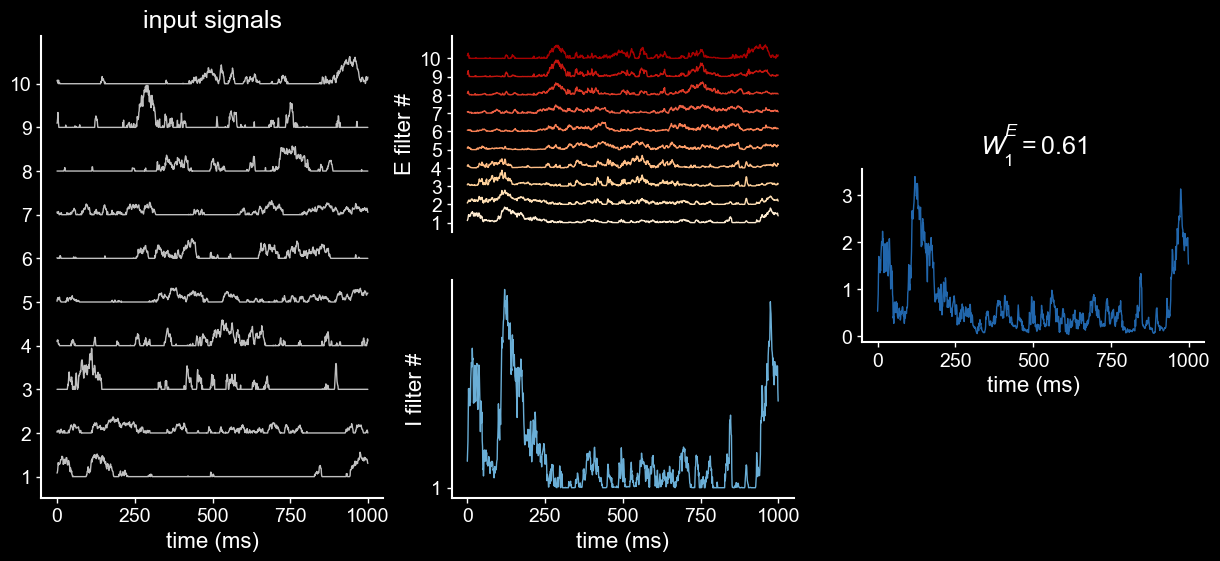

In [7]:
W_E = np.ones(n_E)#/n_E_filters   # weight normalization
W_E[0] = 30

W_I = np.ones(n_I)/n_I   # weight normalization

W_E = W_E/np.sum(W_E + W_I)   # weight normalization
W_I = W_I/np.sum(W_E + W_I)   # weight normalization

print('W_E = ', W_E)
print('W_I = ', W_I)
rate = output_rate(E_pop, I_pop, W_E, W_I)
fig = plot_simulation(signals, E_pop, I_pop, rate, time=t)
plt.gca().set_title(r'$W^E_1 = %1.2f$' % W_E[0])

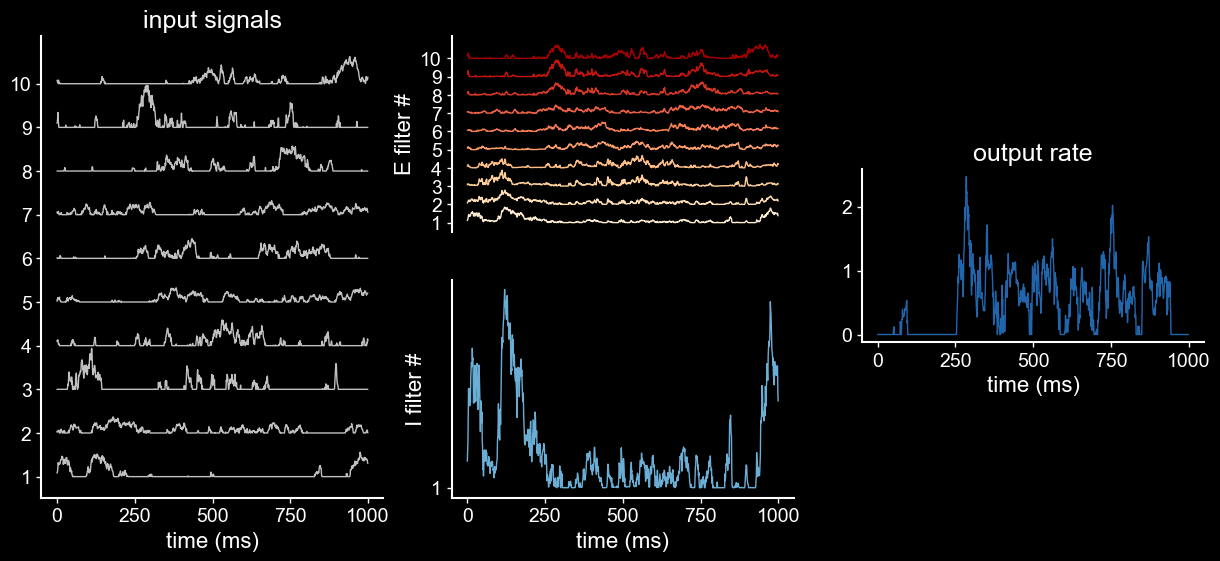

In [8]:
W_E = np.ones(n_E)/n_E   # weight normalization
W_I = np.ones(n_I)/n_I   # weight normalization

rate = output_rate(E_pop, I_pop, W_E, W_I)

fig = plot_simulation(signals, E_pop, I_pop, rate, t)

### Random weights

In [9]:
""" W_E = np.random.rand(1,n_E) #/n_E_filters   
#W_E = W_E + np.min(W_E)

W_I = np.random.rand(1,n_I) #/n_I_filters  
#W_I = W_I + np.min(W_I)

W_E = W_E/np.sum(n_E + n_I)   # weight normalization
print('W_E = ', W_E)
W_I = W_I/np.sum(n_E + n_I)   # weight normalization
print('W_I = ', W_I)
print('Total sum = ', (W_E+W_I))
rate = output_rate(E_pop, I_pop, W_E, W_I)

fig = plot_simulation(signals, E_pop, I_pop, rate, t) """

" W_E = np.random.rand(1,n_E) #/n_E_filters   \n#W_E = W_E + np.min(W_E)\n\nW_I = np.random.rand(1,n_I) #/n_I_filters  \n#W_I = W_I + np.min(W_I)\n\nW_E = W_E/np.sum(n_E + n_I)   # weight normalization\nprint('W_E = ', W_E)\nW_I = W_I/np.sum(n_E + n_I)   # weight normalization\nprint('W_I = ', W_I)\nprint('Total sum = ', (W_E+W_I))\nrate = output_rate(E_pop, I_pop, W_E, W_I)\n\nfig = plot_simulation(signals, E_pop, I_pop, rate, t) "

## Synaptic plasticity

$$\Large\partial_tW_i^E = \eta_EE_j(t)R(t)$$

- $\eta_E$: excitatory learning rate, $\eta_E = \eta_I/10$, unless specified otherwise. 

**Weight-limiting mechanism**: Because previous work has shown that the specific form of the weight limiting mechanism is important for the learning dynamics (Miller & MacKay, 1994), we study both multiplicative and subtractive weight normalization. A multiplicative normalization is vaguely inspired by homeostatic synaptic scaling (Turrigiano et al., 1998). Note that an activity-dependent homeostatic control of the excitatory synaptic weights (rather than a weight-dependent mechanism as used here) is problematic in a situation where inhibitory synapses are also plastic, because neuronal activity and excitatory weights are only weakly coupled. For example, both excitatory and inhibitory weights could diverge although a given mean firing rate is maintained.

1. random weights drawn from a uniform distribution. 

2. **Weight normalization:**

    - For multiplicative normalization, after every weight update, the weights are divided by their L2 norm. 
    - For the subtractive weight normalization, we subtract the average weight $\sum_iW_i^E/N_E$ from all weights and add a constant (here 1). Negative weights, which can arise from this procedure, were clipped to zero. By this procedure, the sum of the weights remains at approximately $N_E$.

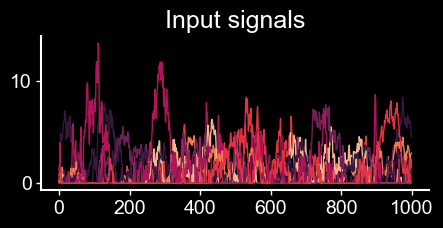

In [10]:
## Generate artificial input signals
n_signals = 10
np.random.seed(0)

decay = 1/50 # τ = 50ms
c = np.linspace(10,100,n_signals) #np.random.randint(10, 20, 10)
mean = 1 
sigma = 100
dur = 1000
dt = 1.
t = np.arange(0, dur, dt)

signals = np.zeros((n_signals, len(t)))
for i in range(n_signals):
    signals[i,:] = OU_input_signal(decay, c[i], mean, sigma, dur, dt)

plt.figure(figsize=(5,2))
sns.set_palette('rocket')
plt.plot(signals.T, linewidth=1.)
plt.title('Input signals')
plt.show()

In [11]:
""" ## Input filters: E, I populations
sigma_E = 1.
sigma_I = 1.
n_E = n_signals
n_I = 1

E_pop = input_filters(signals, sigma=sigma_E, n_filters=n_E)
I_pop = input_filters(signals, sigma=sigma_I, n_filters=n_I)

sns.set_palette('Reds_r')
plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.plot(E_pop.T, linewidth=1.)
plt.title('Excitatory')

sns.set_palette('Blues_r')
plt.subplot(1,2,2)
plt.plot(I_pop.T, linewidth=1.)
plt.title('Inhibitory')

plt.show() """

" ## Input filters: E, I populations\nsigma_E = 1.\nsigma_I = 1.\nn_E = n_signals\nn_I = 1\n\nE_pop = input_filters(signals, sigma=sigma_E, n_filters=n_E)\nI_pop = input_filters(signals, sigma=sigma_I, n_filters=n_I)\n\nsns.set_palette('Reds_r')\nplt.figure(figsize=(10,2))\nplt.subplot(1,2,1)\nplt.plot(E_pop.T, linewidth=1.)\nplt.title('Excitatory')\n\nsns.set_palette('Blues_r')\nplt.subplot(1,2,2)\nplt.plot(I_pop.T, linewidth=1.)\nplt.title('Inhibitory')\n\nplt.show() "

### No normalization

In [12]:
"""
## Initialize weights
W_E0 = np.random.rand(n_E) #/n_E_filters   
W_I0 = np.random.rand(n_I) #/n_I_filters  

#W_E = W_E/np.sum(n_E_filters + n_I_filters)   # weight normalization
# W_E0 = norm(W_E0,'subt')
print('W_E = ', W_E0)
# W_I = W_I/np.sum(n_E_filters + n_I_filters)   # weight normalization
# W_I0 = norm(W_I0,'subt')
print('W_I = ', W_I0)
print('Total sum = ', (W_E0+W_I0))

rate_H, W_E, W_I = simulate(W_E0, W_I0, E_pop, I_pop, norm_type=None)
"""

"\n## Initialize weights\nW_E0 = np.random.rand(n_E) #/n_E_filters   \nW_I0 = np.random.rand(n_I) #/n_I_filters  \n\n#W_E = W_E/np.sum(n_E_filters + n_I_filters)   # weight normalization\n# W_E0 = norm(W_E0,'subt')\nprint('W_E = ', W_E0)\n# W_I = W_I/np.sum(n_E_filters + n_I_filters)   # weight normalization\n# W_I0 = norm(W_I0,'subt')\nprint('W_I = ', W_I0)\nprint('Total sum = ', (W_E0+W_I0))\n\nrate_H, W_E, W_I = simulate(W_E0, W_I0, E_pop, I_pop, norm_type=None)\n"

### Substractive normalization

In [13]:
"""normt = 'subt'

## Initialize weights
W_E0 = np.random.rand(n_E) #/n_E_filters   
W_I0 = np.random.rand(n_I) #/n_I_filters  

#W_E = W_E/np.sum(n_E_filters + n_I_filters)   # weight normalization
W_E0 = norm(W_E0,normt)
print('W_E = ', W_E0)
# W_I = W_I/np.sum(n_E_filters + n_I_filters)   # weight normalization
W_I0 = norm(W_I0,normt)
print('W_I = ', W_I0)
print('Total sum = ', (W_E0+W_I0))

rate_H_subt, W_E_subt, W_I_subt = simulate(W_E0, W_I0, E_pop, I_pop, norm_type=normt)"""

"normt = 'subt'\n\n## Initialize weights\nW_E0 = np.random.rand(n_E) #/n_E_filters   \nW_I0 = np.random.rand(n_I) #/n_I_filters  \n\n#W_E = W_E/np.sum(n_E_filters + n_I_filters)   # weight normalization\nW_E0 = norm(W_E0,normt)\nprint('W_E = ', W_E0)\n# W_I = W_I/np.sum(n_E_filters + n_I_filters)   # weight normalization\nW_I0 = norm(W_I0,normt)\nprint('W_I = ', W_I0)\nprint('Total sum = ', (W_E0+W_I0))\n\nrate_H_subt, W_E_subt, W_I_subt = simulate(W_E0, W_I0, E_pop, I_pop, norm_type=normt)"

### Multiplicative normalization

In [14]:
"""normt = 'mult'

## Initialize weights
W_E0 = np.random.rand(n_E) #/n_E_filters   
W_I0 = np.random.rand(n_I) #/n_I_filters  

#W_E = W_E/np.sum(n_E_filters + n_I_filters)   # weight normalization
W_E0 = norm(W_E0,normt)S
print('W_E = ', W_E0)
# W_I = W_I/np.sum(n_E_filters + n_I_filters)   # weight normalization
W_I0 = norm(W_I0,normt)
print('W_I = ', W_I0)
print('Total sum = ', (W_E0+W_I0))

rate_H_mult, W_E_mult, W_I_mult = simulate(W_E0, W_I0, E_pop, I_pop, norm_type=normt)"""

"normt = 'mult'\n\n## Initialize weights\nW_E0 = np.random.rand(n_E) #/n_E_filters   \nW_I0 = np.random.rand(n_I) #/n_I_filters  \n\n#W_E = W_E/np.sum(n_E_filters + n_I_filters)   # weight normalization\nW_E0 = norm(W_E0,normt)S\nprint('W_E = ', W_E0)\n# W_I = W_I/np.sum(n_E_filters + n_I_filters)   # weight normalization\nW_I0 = norm(W_I0,normt)\nprint('W_I = ', W_I0)\nprint('Total sum = ', (W_E0+W_I0))\n\nrate_H_mult, W_E_mult, W_I_mult = simulate(W_E0, W_I0, E_pop, I_pop, norm_type=normt)"

### Comparison

In [15]:
""" fig = plt.figure(figsize=(10,5))
plt.subplot(2,3,1)
plt.plot(rate_H, 'k', linewidth=1.)
plt.title('no normalization')
plt.subplot(2,3,2)
plt.plot(rate_H_subt, 'k', linewidth=1.)
plt.title('subttractive')
plt.subplot(2,3,3)
plt.plot(rate_H_mult, 'k', linewidth=1.)
plt.title('multiplicative')

plt.subplot(2,3,4)
plot_weights(W_E, W_I, fig)
plt.subplot(2,3,5)
plot_weights(W_E_subt, W_I_subt, fig)
plt.subplot(2,3,6)
plot_weights(W_E_mult, W_I_mult, fig) """

" fig = plt.figure(figsize=(10,5))\nplt.subplot(2,3,1)\nplt.plot(rate_H, 'k', linewidth=1.)\nplt.title('no normalization')\nplt.subplot(2,3,2)\nplt.plot(rate_H_subt, 'k', linewidth=1.)\nplt.title('subttractive')\nplt.subplot(2,3,3)\nplt.plot(rate_H_mult, 'k', linewidth=1.)\nplt.title('multiplicative')\n\nplt.subplot(2,3,4)\nplot_weights(W_E, W_I, fig)\nplt.subplot(2,3,5)\nplot_weights(W_E_subt, W_I_subt, fig)\nplt.subplot(2,3,6)\nplot_weights(W_E_mult, W_I_mult, fig) "

## Unspecific inhibition
Single inhibitory input channel, the activity of which is constant in time. 

The dynamics do not change when, instead, the inhibitory input is an average of the activities of the excitatory inputs 
$$ \large\sigma_I \rightarrow \infty: I(t) = N_E^{-1}\sum_iE_i(t) $$

In simulations where the subtractive normalization amplifies differences in input firing rates (Figs. 5 and 6), one of the stimulus channels $s_j$ was multiplicatively scaled up by 10%.

[0.35284244 0.37472664 0.36589566 0.40399469 0.41567864 0.42556001
 0.42715661 0.44097787 0.44949297 0.46383269]


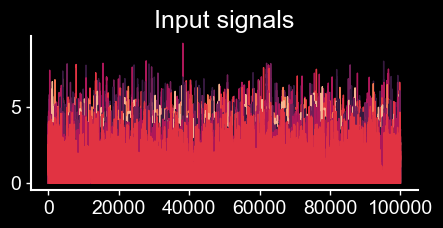

In [2]:
## Generate artificial input signals
n_signals = 10
np.random.seed(0)

decay = 1/50 # τ = 50ms
c = np.linspace(2,10,n_signals) #np.random.randint(10, 20, 10)
mean = 1 
sigma = 4
dur = 1000
dt = .01
t = np.arange(0, dur, dt)

signals = np.zeros((n_signals, len(t)))
for i in range(n_signals):
    signals[i,:] = OU_input_signal(decay, c[i], mean, sigma, dur, dt)
print(sparsity(signals))

#signals = np.roll(signals, 3)

plt.figure(figsize=(5,2))
sns.set_palette('rocket')
plt.plot(signals.T, linewidth=1.)
plt.title('Input signals')
plt.show()

(1, 100000)


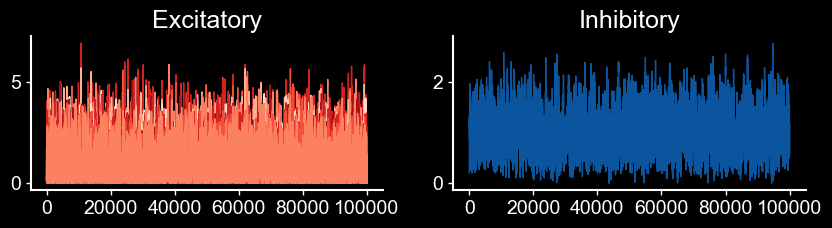

In [3]:
## Input filters: E, I populations
sigma_E = .7
# sigma_I = 8.
n_E = n_signals
n_I = 1

E_pop = input_filters(signals, sigma=sigma_E, n_filters=n_E)
np.random.shuffle(E_pop)
# E_pop = E_pop/1
I_pop = np.mean(E_pop,axis=0).reshape(1,-1)
# I_pop = np.mean(I_pop)*np.ones((1,len(I_pop)))
print(I_pop.shape)

sns.set_palette('Reds_r')
plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.plot(E_pop.T, linewidth=1.)
plt.title('Excitatory')

sns.set_palette('Blues_r')
plt.subplot(1,2,2)
plt.plot(I_pop.T, linewidth=1.)
plt.title('Inhibitory')

plt.show()

In [37]:
normtype = 'mult'
## Initialize weights
a, b = 0., 0.5
W_E0 = np.random.rand(n_E)*(b-a) + a  # generates uniform ranodm numbers in (a, b)
W_I0 = np.array([1.]) #np.random.rand(n_I)*1.2#*(b-a) + a

#W_E = W_E/np.sum(n_E_filters + n_I_filters)   # weight normalization
W_E0 = norm(W_E0,normtype)
print('W_E0 = ', W_E0)
# W_I = W_I/np.sum(n_E_filters + n_I_filters)   # weight normalization
#W_I0 = norm(W_I0,normtype)
print('W_I0 = ', W_I0)
print('Total sum = ', (W_E0+W_I0))

paramsE = {'lr':1e-4, 'target_rate':0., 'norm_type':normtype}
paramsI = {'lr':1e-3, 'target_rate':1., 'norm_type':None}
rate_H, W_E, W_I = simulate(W_E0, W_I0, E_pop, I_pop, paramsE=paramsE, paramsI=paramsI)

W_E0 =  [0.45535822 0.07034702 0.06968077 0.46356504 0.31592344 0.11450782
 0.21561296 0.21708858 0.41893532 0.43117209]
W_I0 =  [1.]
Total sum =  [1.45535822 1.07034702 1.06968077 1.46356504 1.31592344 1.11450782
 1.21561296 1.21708858 1.41893532 1.43117209]


/Users/luciaarancibia/Code/IMBIZO/project/plotting_EI.py:37: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


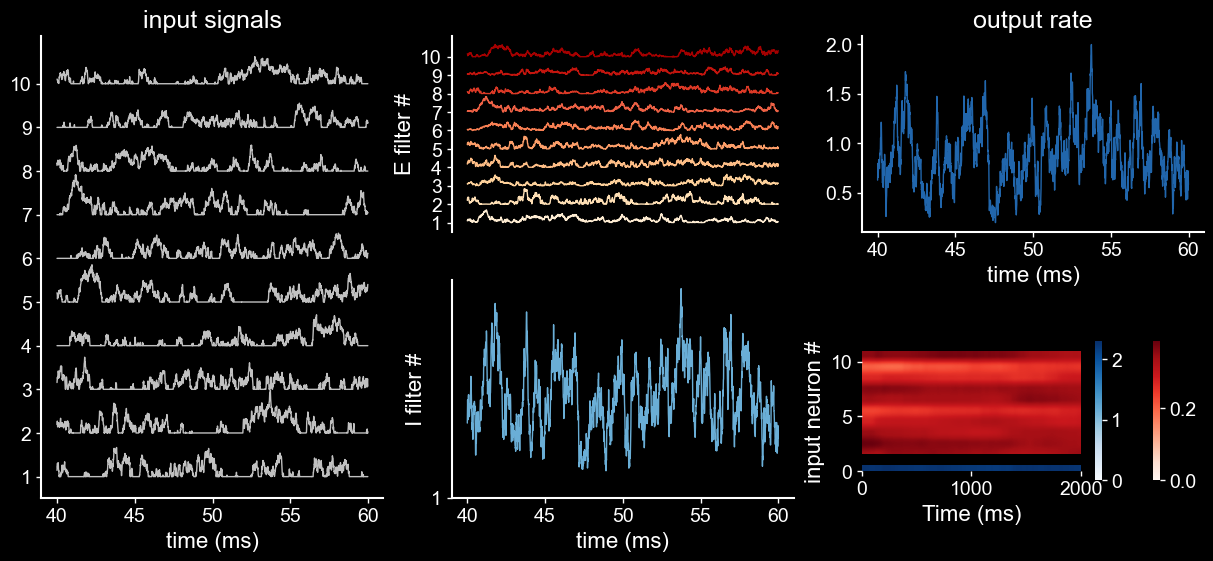

In [38]:
# Plotting activity
ts, te = 4000, 6000
fig, gs = plot_simulation(signals[:, ts:te], E_pop[:, ts:te], I_pop[:, ts:te], rate_H[ts:te], time=t[ts:te], a=(0,9))

plt.subplot(gs[13:, 2])  # rows, columns
plot_weights(W_E[:,ts:te], W_I[:, ts:te], fig)

98000


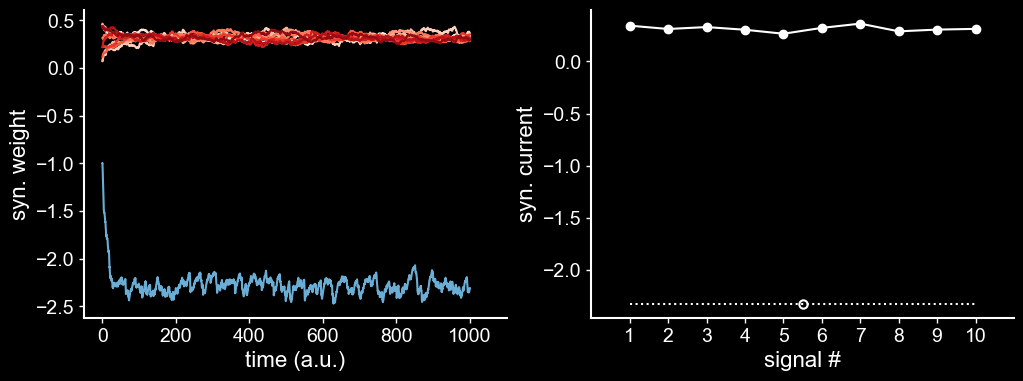

In [40]:
plot_RF(t, W_E, W_I, n_signals)
plt.show()

## Stimulus-specific inhibition

### Symmetric E/I populations

#### No receptive fields for $\eta_E << \eta_I$

Play around with different learning rates and the two normalization types to get the behaviors described in the paper

In [41]:
## Input filters: E, I populations
sigma_pre = .5
n_pre = n_signals

pre_pop = input_filters(signals, sigma=sigma_pre, n_filters=n_E)
np.random.shuffle(pre_pop)
# E_pop = E_pop/1

In [45]:
normtype = 'subt'
## Initialize weights
a, b = 0., .6
W_E0 = np.random.rand(n_pre)*(b-a) + a  # generates uniform ranodm numbers in (a, b)
W_I0 = np.random.rand(n_pre)*(b-a) + a

#W_E = W_E/np.sum(n_E_filters + n_I_filters)   # weight normalization
# W_E0 = norm(W_E0,normtype)
print('W_E0 = ', W_E0)
# W_I = W_I/np.sum(n_E_filters + n_I_filters)   # weight normalization
# W_I0 = norm(W_I0,normtype)
print('W_I0 = ', W_I0)
print('Total sum = ', (W_E0+W_I0))

paramsE = {'lr':1e-4, 'target_rate':0., 'norm_type':normtype}
paramsI = {'lr':1e-3, 'target_rate':1., 'norm_type':normtype}
rate_H, W_E, W_I = simulate(W_E0, W_I0, pre_pop, pre_pop, paramsE=paramsE, paramsI=paramsI)

W_E0 =  [0.45769254 0.48085615 0.06184997 0.23924041 0.58827938 0.43915979
 0.03950141 0.09808768 0.58167798 0.3207772 ]
W_I0 =  [0.15425711 0.07764534 0.18939166 0.16273823 0.21036775 0.05477963
 0.50074712 0.33210268 0.06853276 0.36454617]
Total sum =  [0.61194965 0.55850148 0.25124162 0.40197865 0.79864714 0.49393943
 0.54024853 0.43019035 0.65021073 0.68532337]


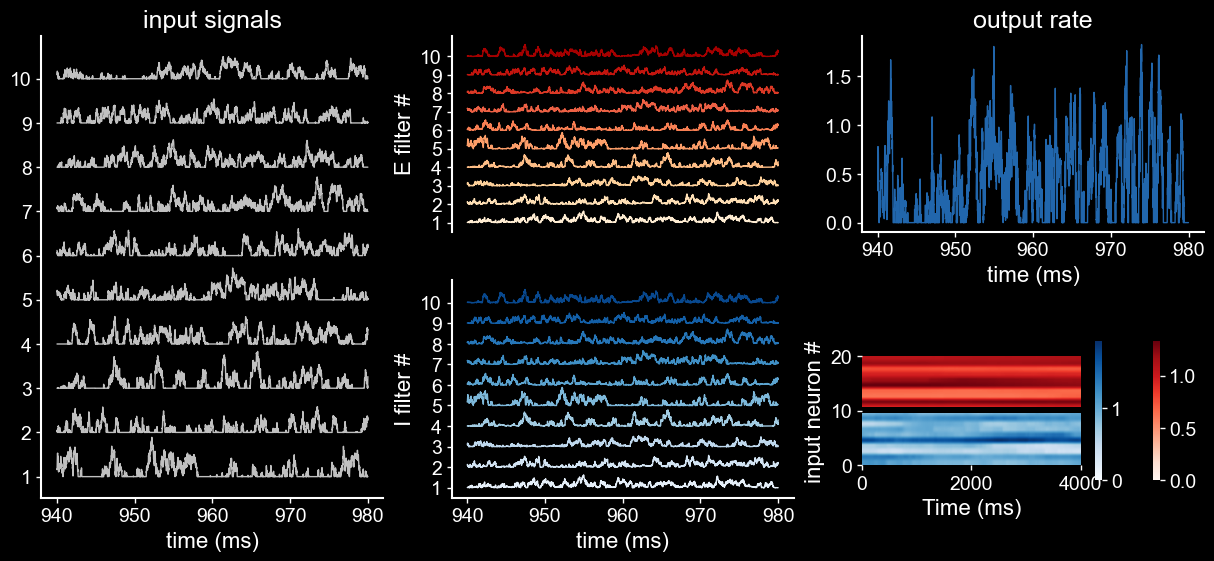

In [46]:
# Plotting activity
ts, te = 94000, 98000
fig, gs = plot_simulation(signals[:, ts:te], pre_pop[:, ts:te], pre_pop[:, ts:te], rate_H[ts:te], time=t[ts:te], a=(0,9))

plt.subplot(gs[13:, 2])  # rows, columns
plot_weights(W_E[:,ts:te], W_I[:, ts:te], fig)

98000


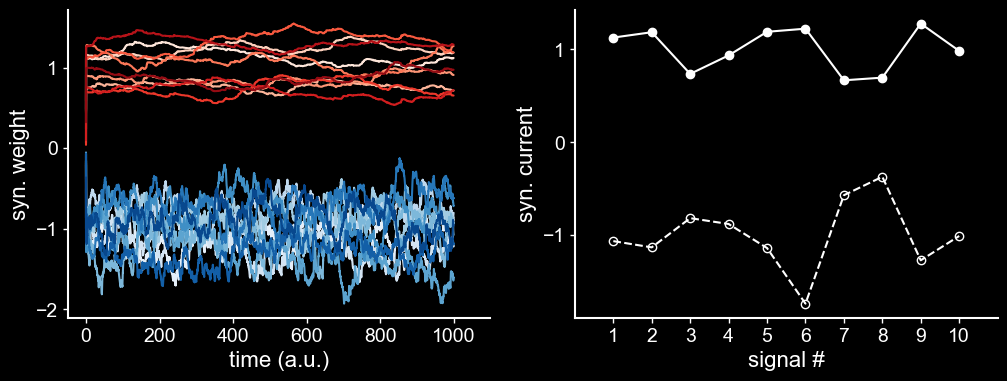

In [47]:
plot_RF(t, W_E, W_I, n_signals)
# plt.ylim(-1.1, 1.1)
plt.yticks(np.array([-1, 0, 1]))
plt.show()

### Increasing $\eta_E$ generates oscilating receptive fields

In [48]:
normtype = 'subt'
## Initialize weights
a, b = 0., .6
W_E0 = np.random.rand(n_pre)*(b-a) + a  # generates uniform ranodm numbers in (a, b)
W_I0 = np.random.rand(n_pre)*(b-a) + a

#W_E = W_E/np.sum(n_E_filters + n_I_filters)   # weight normalization
# W_E0 = norm(W_E0,normtype)
print('W_E0 = ', W_E0)
# W_I = W_I/np.sum(n_E_filters + n_I_filters)   # weight normalization
# W_I0 = norm(W_I0,normtype)
print('W_I0 = ', W_I0)
print('Total sum = ', (W_E0+W_I0))

paramsE = {'lr':15e-4, 'target_rate':0., 'norm_type':normtype}
paramsI = {'lr':10e-4, 'target_rate':1., 'norm_type':normtype}
rate_H, W_E, W_I = simulate(W_E0, W_I0, pre_pop, pre_pop, paramsE=paramsE, paramsI=paramsI)

W_E0 =  [0.30532141 0.18328413 0.20506709 0.32240982 0.54302291 0.42055965
 0.11697396 0.41695266 0.59989626 0.16515162]
W_I0 =  [0.08734696 0.3803168  0.25450038 0.36725466 0.29203703 0.33902971
 0.49496875 0.39114596 0.09742326 0.4100356 ]
Total sum =  [0.39266837 0.56360093 0.45956746 0.68966448 0.83505994 0.75958936
 0.61194271 0.80809862 0.69731952 0.57518722]


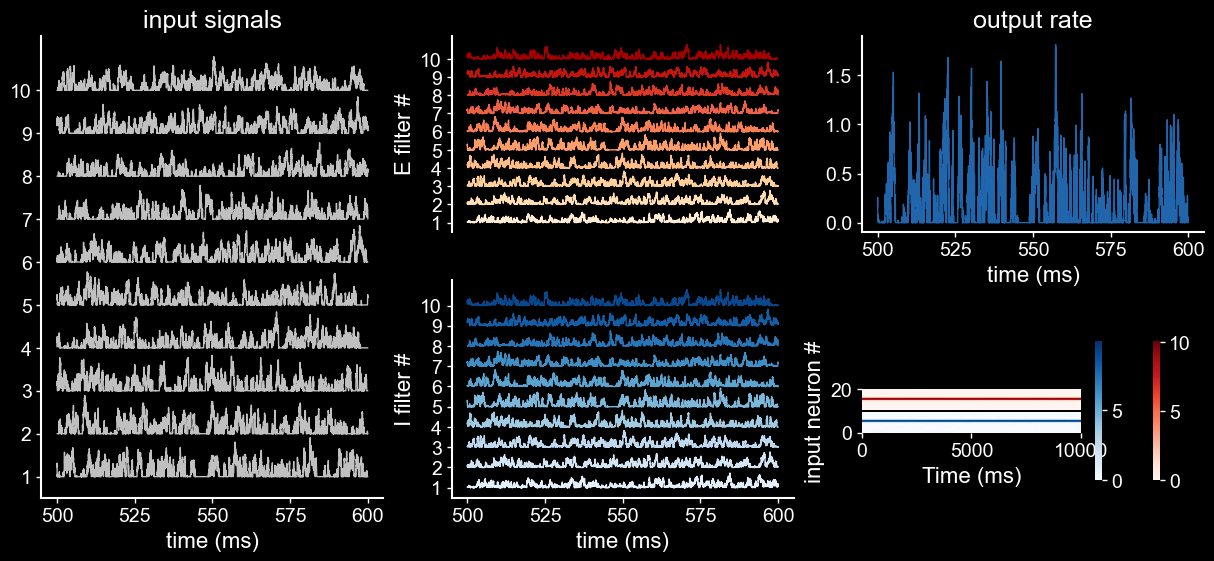

In [49]:
# Plotting activity
ts, te = 50000, 60000
fig, gs = plot_simulation(signals[:, ts:te], pre_pop[:, ts:te], pre_pop[:, ts:te], rate_H[ts:te], time=t[ts:te], a=(0,9))

plt.subplot(gs[13:, 2])  # rows, columns
plot_weights(W_E[:,ts:te], W_I[:, ts:te], fig)

98000


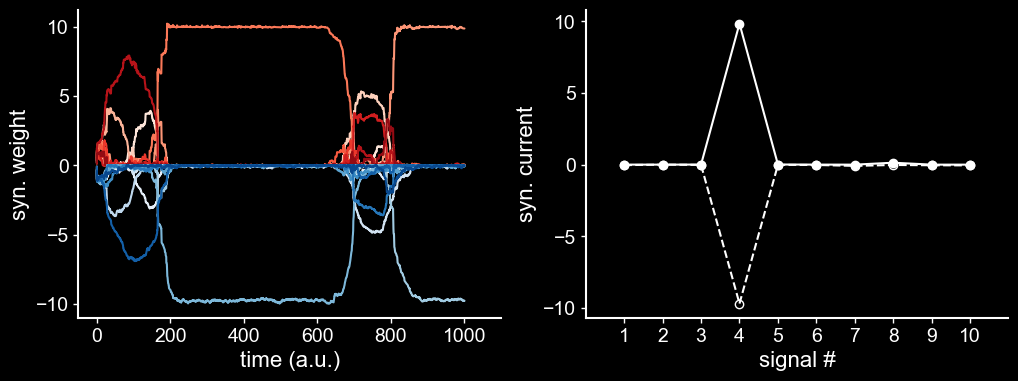

In [50]:
plot_RF(t, W_E, W_I, n_signals)
plt.show()

### Changing presynaptic tuning generates stable receptive fields

Increase one signal's amplitude by 10% to increase preference

In [149]:
signals = signals/1.5
signals[6,:] = signals[6,:]*2.5

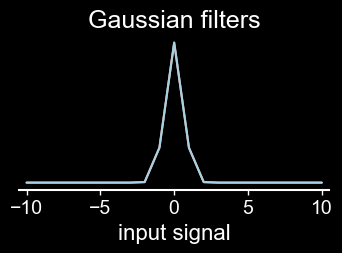

In [150]:
## Input filters: E, I populations
sigma_E = .6
sigma_I = .6
n_E = n_signals
n_I = n_signals

sns.set_palette('RdBu',2)
plt.figure(figsize=(4,2))
E_pop = input_filters(signals, sigma=sigma_E, n_filters=n_E, plot_gauss=True)
# np.random.shuffle(E_pop)
# E_pop = E_pop/1
I_pop = input_filters(signals, sigma=sigma_I, n_filters=n_I, plot_gauss=True)

In [151]:
normtype = 'subt'
## Initialize weights
a, b = 0., 0.6
W_E0 = np.random.rand(n_E)*(b-a) + a  # generates uniform ranodm numbers in (a, b)
W_I0 = np.random.rand(n_I)*(b-a) + a#np.random.rand(n_I)*1.2#*(b-a) + a

#W_E = W_E/np.sum(n_E_filters + n_I_filters)   # weight normalization
W_E0 = norm(W_E0,normtype)
print('W_E0 = ', W_E0)
# W_I = W_I/np.sum(n_E_filters + n_I_filters)   # weight normalization
W_I0 = norm(W_I0,normtype)
print('W_I0 = ', W_I0)
print('Total sum = ', (W_E0+W_I0))

paramsE = {'lr':1e-4, 'target_rate':0., 'norm_type':normtype}
paramsI = {'lr':1e-4, 'target_rate':1., 'norm_type':normtype}
rate_H, W_E, W_I = simulate(W_E0, W_I0, pre_pop, pre_pop, paramsE=paramsE, paramsI=paramsI)

W_E0 =  [0.80790281 1.07868475 0.88527857 0.89767823 0.71162663 1.2508359
 1.09193219 1.05458722 1.11311615 1.10835755]
W_I0 =  [0.84986273 0.94149295 1.06029118 0.89988338 1.16093789 0.96786686
 1.31343808 0.85135035 1.00454001 0.95033656]
Total sum =  [1.65776555 2.0201777  1.94556975 1.79756161 1.87256452 2.21870276
 2.40537027 1.90593758 2.11765617 2.05869411]


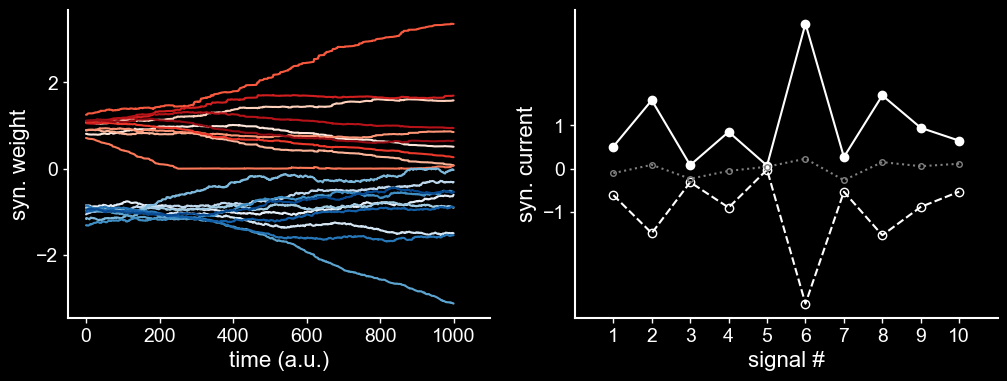

In [152]:
plot_RF(t, W_E, W_I, n_signals, plot_net=True, en_idx=np.where(t==999.)[0][0])
# plt.ylim(-1.1, 1.1)
plt.yticks(np.array([-1, 0, 1]))
plt.show()

/Users/luciaarancibia/Code/IMBIZO/project/plotting_EI.py:37: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


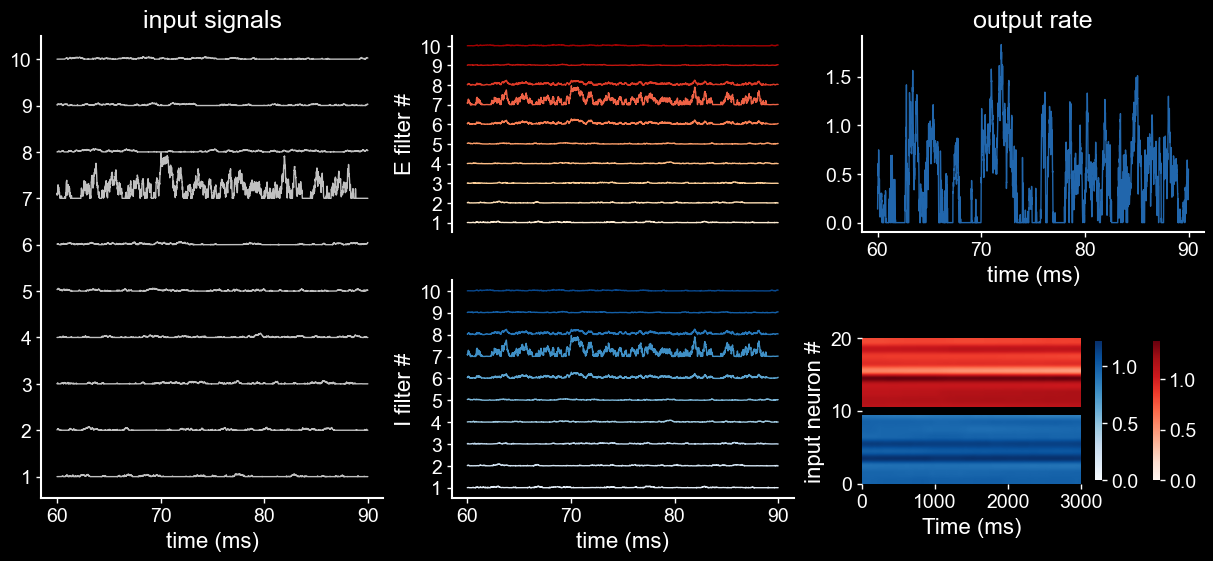

In [153]:
# Plotting activity
ts, te = 6000, 9000
fig, gs = plot_simulation(signals[:, ts:te], E_pop[:, ts:te], I_pop[:, ts:te], rate_H[ts:te], time=t[ts:te], a=(0,9))

plt.subplot(gs[13:, 2])  # rows, columns
plot_weights(W_E[:,ts:te], W_I[:, ts:te], fig)

### Check output rates with different contrast for learnt weights

[10.          3.84615385  2.38095238  1.72413793  1.35135135  1.11111111]


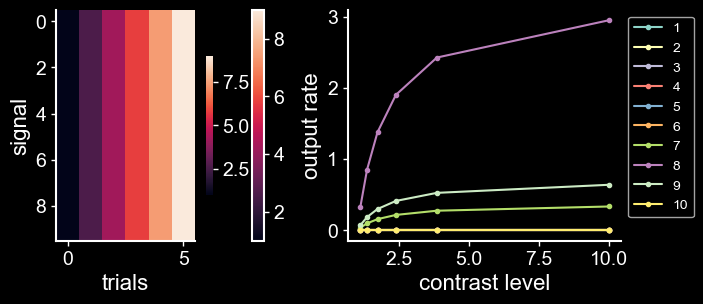

In [133]:
n_cont = 6
max_value = 10.
cont_signal = np.ones((n_E,n_cont))
background = np.linspace(1,9,n_cont)
cont_signal = cont_signal*background

contrast = max_value/background
print(contrast)

plt.figure(figsize=(12,3))

plt.subplot(1,3,1)
plt.imshow(cont_signal)
plt.colorbar()
plt.xlabel('trials')
plt.ylabel('signal')

plt.subplot(1,3,2)
plt.xlabel('contrast level')
plt.ylabel('output rate')

out = np.zeros((n_cont, n_signals))
for i in range(n_signals):
    c = np.copy(cont_signal)
    c[i,:] = 10.

    E_cont = input_filters(c, sigma=sigma_E, n_signals=n_signals, n_filters=n_E)
    I_cont = input_filters(c, sigma=sigma_I, n_signals=n_signals, n_filters=n_I)
    out[:,i] = output_rate(E_cont, I_cont, W_E[:,-1], W_I[:,-1])

    plt.plot(contrast, out[:,i], 'o-', label=i+1)
# plt.imshow(out)
plt.legend(bbox_to_anchor=(1,1), fontsize=10.)
cb1 = plt.colorbar(shrink=0.6)
cb1.outline.set_visible(False)
lims = plt.ylim()

# cont_signal2 = np.copy(cont_signal)
# cont_signal2[2,:] = 8.
# E_cont2 = input_filters(cont_signal2, sigma=sigma_E, n_signals=n_signals, n_filters=n_E)
# I_cont2 = input_filters(cont_signal2, sigma=sigma_I, n_signals=n_signals, n_filters=n_I)
# out2 = output_rate(E_cont2, I_cont2, W_E[:,-1], W_I[:,-1])
# contrast = 10./background
# plt.subplot(1,3,3)
# plt.plot(contrast, out2)
# plt.xlabel('contrast level')
# plt.ylabel('output rate')
# plt.ylim(lims)

plt.show()

/Users/luciaarancibia/Code/IMBIZO/plotting_EI.py:37: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


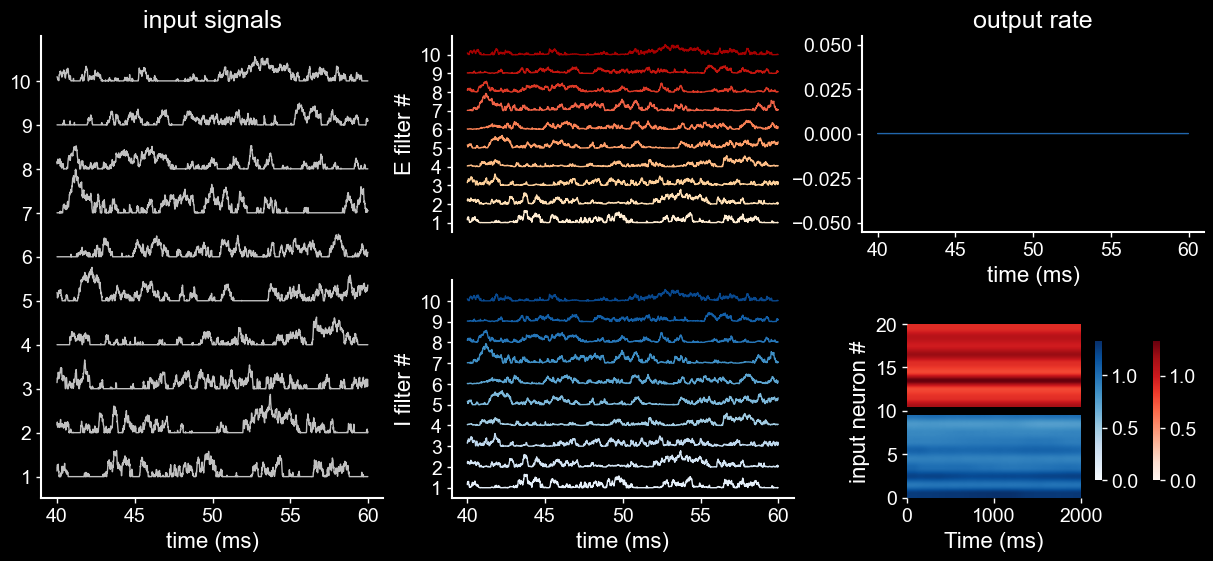

In [30]:
# Plotting activity
ts, te = 4000, 6000
fig, gs = plot_simulation(signals[:, ts:te], E_pop[:, ts:te], I_pop[:, ts:te], rate_H[ts:te], time=t[ts:te], a=(0,9))

plt.subplot(gs[13:, 2])  # rows, columns
plot_weights(W_E[:,ts:te], W_I[:, ts:te], fig)

### Broader inhibitory input

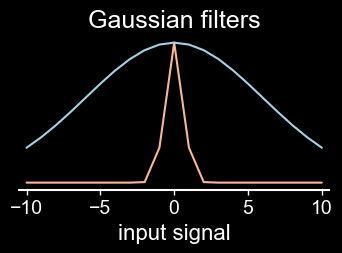

In [383]:
## Input filters: E, I populations
sigma_E = .6
sigma_I = 6.
n_E = n_signals
n_I = n_signals

sns.set_palette('RdBu',2)
plt.figure(figsize=(4,2))
E_pop = input_filters(signals, sigma=sigma_E, n_filters=n_E, plot_gauss=True)
# np.random.shuffle(E_pop)
# E_pop = E_pop/1
I_pop = input_filters(signals, sigma=sigma_I, n_filters=n_I, plot_gauss=True)

In [390]:
normtype = 'mult'
## Initialize weights
a, b = 0., 0.6
W_E0 = np.random.rand(n_E)*(b-a) + a  # generates uniform ranodm numbers in (a, b)
W_I0 = np.random.rand(n_I)*(b-a) + a#np.random.rand(n_I)*1.2#*(b-a) + a

#W_E = W_E/np.sum(n_E_filters + n_I_filters)   # weight normalization
W_E0 = norm(W_E0,normtype)
print('W_E0 = ', W_E0)
# W_I = W_I/np.sum(n_E_filters + n_I_filters)   # weight normalization 
W_I0 = norm(W_I0,normtype)
print('W_I0 = ', W_I0)
print('Total sum = ', (W_E0+W_I0))

rate_H, W_E, W_I = simulate(W_E0, W_I0, E_pop, I_pop, lr_I=10e-4, lr_E=1e-4, E_trate=0., I_trate=.1, Enorm_type=normtype, Inorm_type=normtype)

W_E0 =  [0.39153696 0.21786521 0.18407069 0.13545949 0.41744163 0.09459631
 0.48197395 0.32905222 0.46628132 0.07618247]
W_I0 =  [0.4301877  0.07730646 0.49969405 0.26282946 0.29201509 0.52234346
 0.1744655  0.17797783 0.23543215 0.12054325]
Total sum =  [0.82172466 0.29517167 0.68376473 0.39828895 0.70945671 0.61693977
 0.65643946 0.50703005 0.70171347 0.19672572]


98000


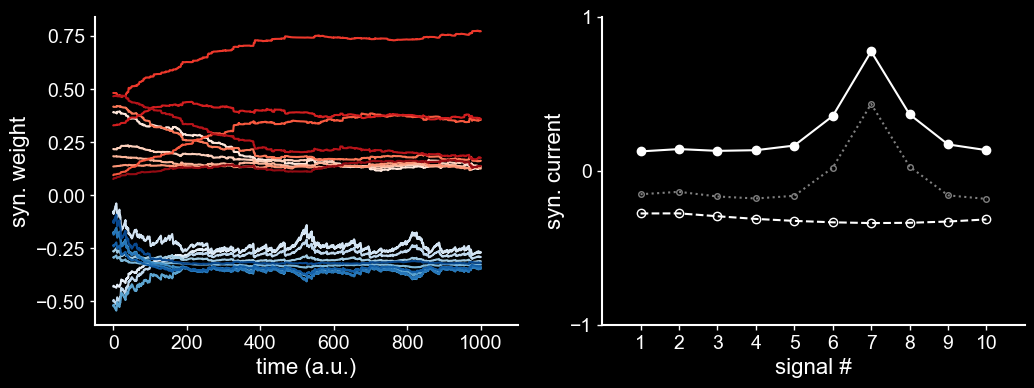

In [391]:
plot_RF(t, W_E, W_I, n_signals, plot_net=True)
# plt.ylim(-1.1, 1.1)
plt.yticks(np.array([-1, 0, 1]))
plt.show()

# Anti-hebbian inhibitory plasticity

[0.35284244 0.37472664 0.36589566 0.40399469 0.41567864 0.42556001
 0.42715661 0.44097787 0.44949297 0.46383269]


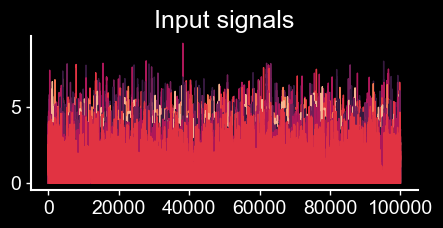

In [3]:
## Generate artificial input signals
n_signals = 10
np.random.seed(0)

decay = 1/50 # τ = 50ms
c = np.linspace(2,10,n_signals) #np.random.randint(10, 20, 10)
mean = 1 
sigma = 4
dur = 1000
dt = .01
t = np.arange(0, dur, dt)

signals = np.zeros((n_signals, len(t)))
for i in range(n_signals):
    signals[i,:] = OU_input_signal(decay, c[i], mean, sigma, dur, dt)
print(sparsity(signals))

#signals = np.roll(signals, 3)

plt.figure(figsize=(5,2))
sns.set_palette('rocket')
plt.plot(signals.T, linewidth=1.)
plt.title('Input signals')
plt.show()

In [6]:
## Input filters: E, I populations
sigma_pre = .5
n_pre = n_signals

pre_pop = input_filters(signals, sigma=sigma_pre, n_filters=n_pre)
np.random.shuffle(pre_pop)
# E_pop = E_pop/1

In [12]:
normtype = 'mult'
## Initialize weights
a, b = 0., .6
W_E0 = np.random.rand(n_pre)*(b-a) + a  # generates uniform ranodm numbers in (a, b)
W_I0 = np.random.rand(n_pre)*(b-a) + a

#W_E = W_E/np.sum(n_E_filters + n_I_filters)   # weight normalization
# W_E0 = norm(W_E0,normtype)
print('W_E0 = ', W_E0)
# W_I = W_I/np.sum(n_E_filters + n_I_filters)   # weight normalization
# W_I0 = norm(W_I0,normtype)
print('W_I0 = ', W_I0)
print('Total sum = ', (W_E0+W_I0))

rate_H, W_E, W_I = simulate(W_E0, W_I0, pre_pop, pre_pop, lr_I=10e-5, lr_E=15e-3, E_trate=0., I_trate=10., Enorm_type=normtype, Inorm_type=normtype)

W_E0 =  [0.26820698 0.13652048 0.34350484 0.00425586 0.41529898 0.24833869
 0.40318718 0.48736008 0.38888761 0.10751779]
W_I0 =  [0.44485789 0.31438913 0.1055333  0.04855328 0.37009297 0.48736258
 0.07361796 0.58111086 0.54293865 0.54701424]
Total sum =  [0.71306488 0.45090961 0.44903814 0.05280914 0.78539195 0.73570127
 0.47680514 1.06847095 0.93182626 0.65453203]


/Users/luciaarancibia/Code/IMBIZO/plotting_EI.py:37: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


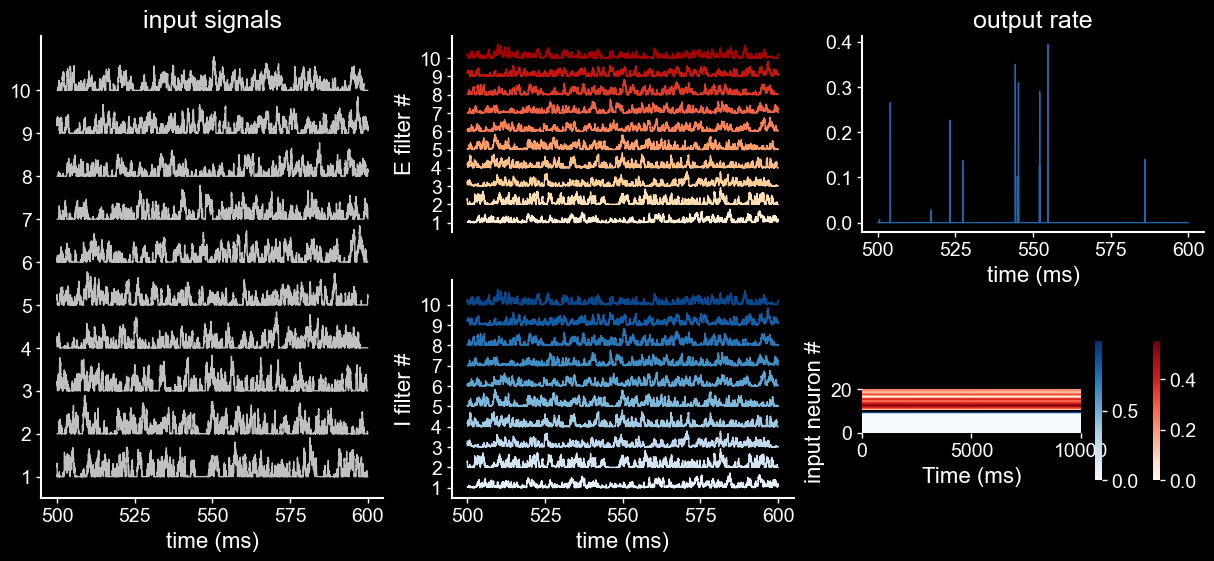

In [13]:
# Plotting activity
ts, te = 50000, 60000
fig, gs = plot_simulation(signals[:, ts:te], pre_pop[:, ts:te], pre_pop[:, ts:te], rate_H[ts:te], time=t[ts:te], a=(0,9))

plt.subplot(gs[13:, 2])  # rows, columns
plot_weights(W_E[:,ts:te], W_I[:, ts:te], fig)

98000


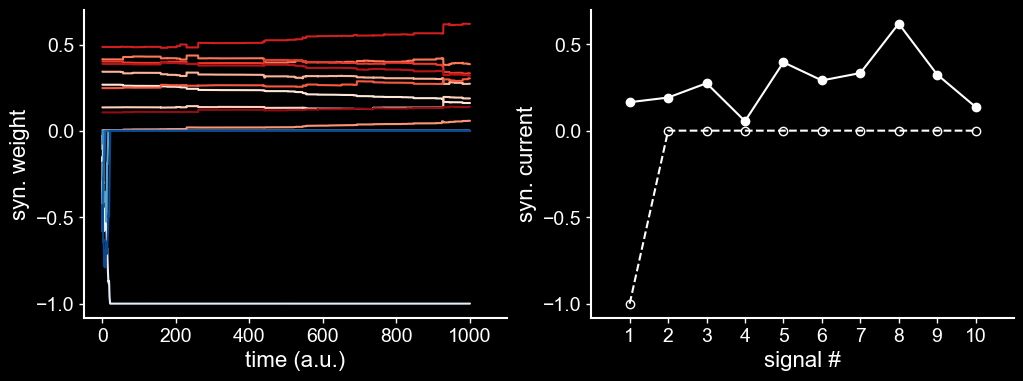

In [14]:
plot_RF(t, W_E, W_I, n_signals)
plt.show()

### Changing presynaptic tuning generates stable receptive fields

Increase one signal's amplitude by 10% to increase preference

In [ ]:
signals[6,:] = signals[6,:]*1.1

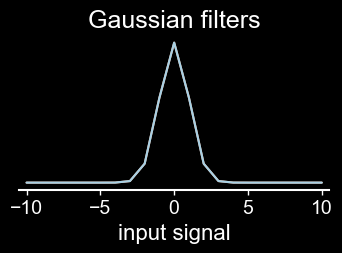

In [ ]:
## Input filters: E, I populations
sigma_E = 1.
sigma_I = 1.
n_E = n_signals
n_I = n_signals

sns.set_palette('RdBu',2)
plt.figure(figsize=(4,2))
E_pop = input_filters(signals, sigma=sigma_E, n_filters=n_E, plot_gauss=True)
# np.random.shuffle(E_pop)
# E_pop = E_pop/1
I_pop = input_filters(signals, sigma=sigma_I, n_filters=n_I, plot_gauss=True)

In [ ]:
normtype = 'subt'
## Initialize weights
a, b = 0., 0.6
W_E0 = np.random.rand(n_E)*(b-a) + a  # generates uniform ranodm numbers in (a, b)
W_I0 = np.random.rand(n_I)*(b-a) + a#np.random.rand(n_I)*1.2#*(b-a) + a

#W_E = W_E/np.sum(n_E_filters + n_I_filters)   # weight normalization
W_E0 = norm(W_E0,normtype)
print('W_E0 = ', W_E0)
# W_I = W_I/np.sum(n_E_filters + n_I_filters)   # weight normalization
W_I0 = norm(W_I0,normtype)
print('W_I0 = ', W_I0)
print('Total sum = ', (W_E0+W_I0))

rate_H, W_E, W_I = simulate(W_E0, W_I0, E_pop, I_pop, lr_I=1e-4, lr_E=10e-4, E_trate=0., I_trate=.1, Enorm_type=normtype, Inorm_type=normtype)

W_E0 =  [1.20840324 1.07431479 1.20818154 1.08143694 1.25990478 0.87021179
 0.79842313 0.77721933 0.67676351 1.04514094]
W_I0 =  [1.09621724 0.90319905 0.93725647 1.0254622  0.92337702 0.800118
 0.93210317 1.02365869 1.13033513 1.22827303]
Total sum =  [2.30462049 1.97751384 2.145438   2.10689915 2.1832818  1.67032978
 1.73052631 1.80087802 1.80709865 2.27341396]
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/luciaarancibia/miniconda3/envs/imbizo/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/fm/pb8w1lmx4rx7dm6034hc5t4w0000gn/T/ipykernel_24236/3672023959.py", line 15, in <module>
    rate_H, W_E, W_I = simulate(W_E0, W_I0, E_pop, I_pop, lr_I=1e-4, lr_E=10e-4, E_trate=0., I_trate=.1, Enorm_type=normtype, Inorm_type=normtype)
  File "/Users/luciaarancibia/Code/IMBIZO/EI_balance_functions.py", line 164, in simulate
    rate[t+1] = output_rate(E_input[:,t+1], I_input[:,t+1], W_E[:,t+1], W_I[:,t+1], WI_anti=W_Ianti[:,t+1])
TypeError: output_rate() got an unexpected keyword argument 'WI_anti'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/luciaarancibia/miniconda3/envs/imbizo/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2102, in showtracebac

98000


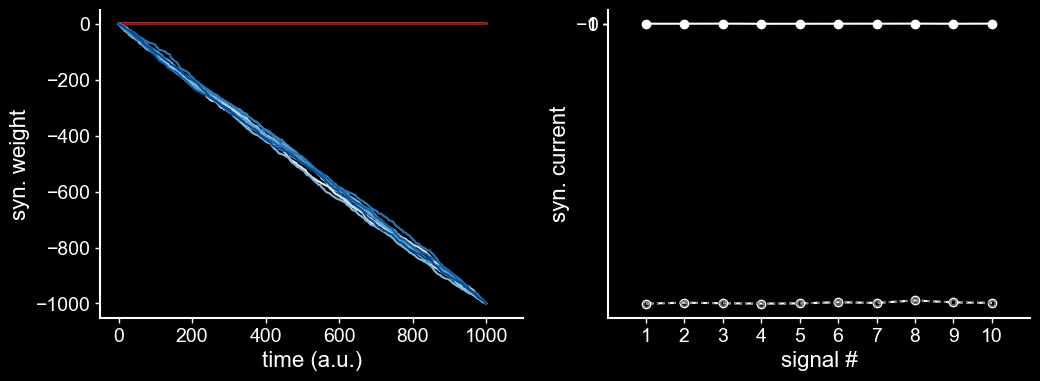

In [ ]:
plot_RF(t, W_E, W_I, n_signals, plot_net=True)
# plt.ylim(-1.1, 1.1)
plt.yticks(np.array([-1, 0, 1]))
plt.show()

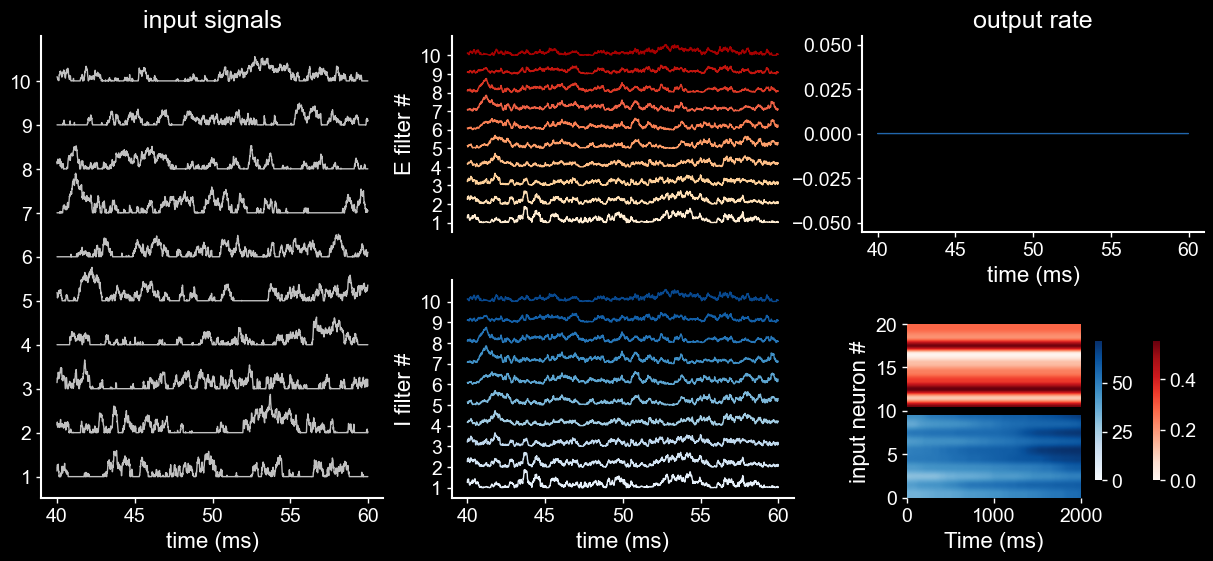

In [ ]:
# Plotting activity
ts, te = 4000, 6000
fig, gs = plot_simulation(signals[:, ts:te], E_pop[:, ts:te], I_pop[:, ts:te], rate_H[ts:te], time=t[ts:te], a=(0,9))

plt.subplot(gs[13:, 2])  # rows, columns
plot_weights(W_E[:,ts:te], W_I[:, ts:te], fig)

### Broader inhibitory input

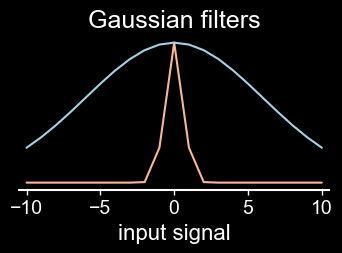

In [ ]:
## Input filters: E, I populations
sigma_E = .6
sigma_I = 6.
n_E = n_signals
n_I = n_signals

sns.set_palette('RdBu',2)
plt.figure(figsize=(4,2))
E_pop = input_filters(signals, sigma=sigma_E, n_filters=n_E, plot_gauss=True)
# np.random.shuffle(E_pop)
# E_pop = E_pop/1
I_pop = input_filters(signals, sigma=sigma_I, n_filters=n_I, plot_gauss=True)

In [ ]:
normtype = 'mult'
## Initialize weights
a, b = 0., 0.6
W_E0 = np.random.rand(n_E)*(b-a) + a  # generates uniform ranodm numbers in (a, b)
W_I0 = np.random.rand(n_I)*(b-a) + a#np.random.rand(n_I)*1.2#*(b-a) + a

#W_E = W_E/np.sum(n_E_filters + n_I_filters)   # weight normalization
W_E0 = norm(W_E0,normtype)
print('W_E0 = ', W_E0)
# W_I = W_I/np.sum(n_E_filters + n_I_filters)   # weight normalization 
W_I0 = norm(W_I0,normtype)
print('W_I0 = ', W_I0)
print('Total sum = ', (W_E0+W_I0))

rate_H, W_E, W_I = simulate(W_E0, W_I0, E_pop, I_pop, lr_I=10e-4, lr_E=1e-4, E_trate=0., I_trate=.1, Enorm_type=normtype, Inorm_type=normtype)

W_E0 =  [0.25515172 0.1896549  0.48977941 0.00522847 0.11917364 0.21789943
 0.31486435 0.49964361 0.10508014 0.48734973]
W_I0 =  [0.42574639 0.0027778  0.02770285 0.17570148 0.30407421 0.2517978
 0.28209292 0.60045142 0.40977105 0.15231527]
Total sum =  [0.68089811 0.1924327  0.51748226 0.18092996 0.42324784 0.46969723
 0.59695727 1.10009503 0.51485119 0.639665  ]
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/luciaarancibia/miniconda3/envs/imbizo/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/fm/pb8w1lmx4rx7dm6034hc5t4w0000gn/T/ipykernel_24236/4229099024.py", line 15, in <module>
    rate_H, W_E, W_I = simulate(W_E0, W_I0, E_pop, I_pop, lr_I=10e-4, lr_E=1e-4, E_trate=0., I_trate=.1, Enorm_type=normtype, Inorm_type=normtype)
  File "/Users/luciaarancibia/Code/IMBIZO/EI_balance_functions.py", line 164, in simulate
    rate[t+1] = output_rate(E_input[:,t+1], I_input[:,t+1], W_E[:,t+1], W_I[:,t+1], WI_anti=W_Ianti[:,t+1])
TypeError: output_rate() got an unexpected keyword argument 'WI_anti'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/luciaarancibia/miniconda3/envs/imbizo/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2102, in showtracebac

98000


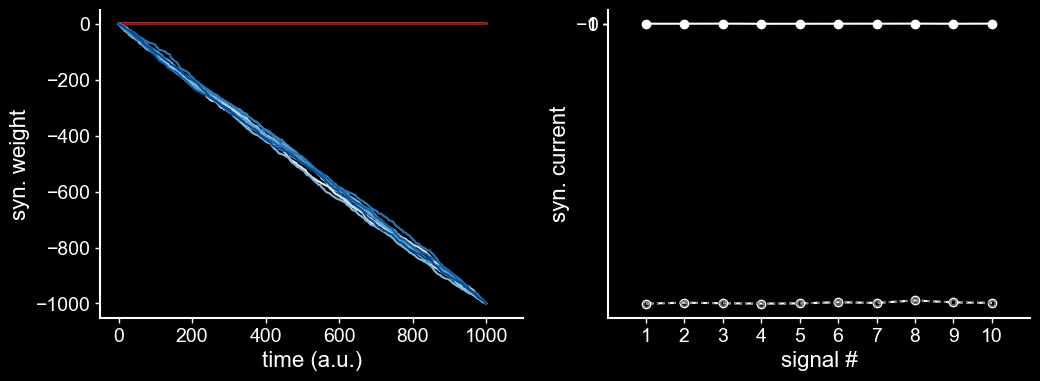

In [ ]:
plot_RF(t, W_E, W_I, n_signals, plot_net=True)
# plt.ylim(-1.1, 1.1)
plt.yticks(np.array([-1, 0, 1]))
plt.show()

# Figures for creative purposes

[]

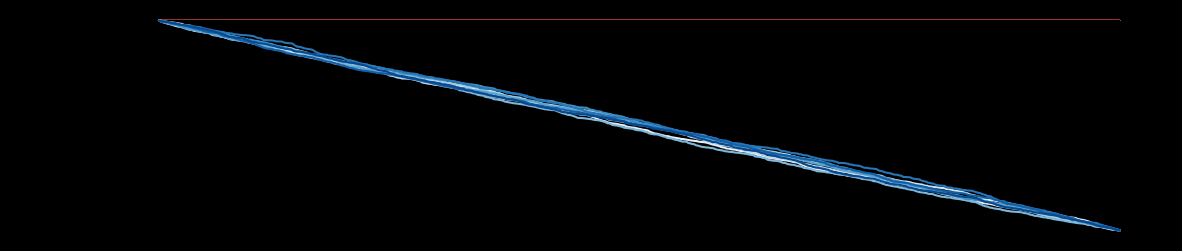

In [ ]:
sns.set_palette('Reds',n_E)
fig, ax = plt.subplots(1,1,figsize=(15,3))
for i in range(n_E): 
    ax.plot(t, W_E[i,:], label='$E_{%i}$' % i, linewidth=1)
plt.hlines(0,-100,dur,'k')
# ax[0].legend(bbox_to_anchor=(1.,1))
# ax.set_title(r'$\sigma_E = %1.1f$, weight normalization: %s' % (sigma_E, normtype), fontsize=12)
# ax[0].plot(t, -W_I.T/10, color='#2b7bba', linewidth=2)
#ax[0].set_yticklabels([])
bl  = sns.color_palette('Blues',n_I).as_hex()
for i in range(n_E): 
    ax.plot(t, -W_I[i,:], label='$I_{%i}$' % i, linewidth=1.5, color = bl[i])
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])


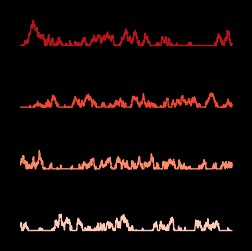

In [ ]:
sns.set_palette('Reds', 4)
sc=20
plt.figure(figsize=(3,3))
plt.plot(t[ts:te], signals[[0, 2, 5, 6],ts:te].T + np.arange(0,4*sc,sc),linewidth=1.)  
plt.xticks([])
plt.gca().spines['bottom'].set_visible(False)
plt.yticks([])
plt.gca().spines['left'].set_visible(False)